In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/used-car-price-prediction/used_car_price_dataset_extended.csv


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

## 1. Introduction

**Problem Statement**

The used car market is dynamic and complex, whereby car prices are influenced by multiple factors such as manufacturing year, mileage, engine size, fuel type, ownership history, and more. Therefore, to accurately predict the resale price of a used car is a valuable techniique that buyers, sellers, and dealerships can use to make informed decisions. Our challenge lies in developing a robust machine learning model that can capture the intricate relationships between these features.

**Project Objective**

The objective of this project is to build a machine learning model to predict the resale price of used cars (price_usd) based on features like make_year, mileage_kmpl, engine_cc, fuel_type, owner_count, brand, transmission, color, service_history, accidents_reported, and insurance_valid. The model will be developed using the stadanrd machine learning pipeline, which includes  exploratory data analysis (EDA), feature engineering, model selection, hyperparameter tuning, and evaluation. At the end, we hope to develop a model with high predictive performance (e.g., low RMSE).

## 2. Data Exploration

In [13]:
# Load data
data = pd.read_csv('/kaggle/input/used-car-price-prediction/used_car_price_dataset_extended.csv')

In [14]:
# Display basic information about the dataset
print("Dataset Info:")
print(data.info())
print("\nFirst 5 Rows:")
print(data.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   make_year           10000 non-null  int64  
 1   mileage_kmpl        10000 non-null  float64
 2   engine_cc           10000 non-null  int64  
 3   fuel_type           10000 non-null  object 
 4   owner_count         10000 non-null  int64  
 5   price_usd           10000 non-null  float64
 6   brand               10000 non-null  object 
 7   transmission        10000 non-null  object 
 8   color               10000 non-null  object 
 9   service_history     7962 non-null   object 
 10  accidents_reported  10000 non-null  int64  
 11  insurance_valid     10000 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 937.6+ KB
None

First 5 Rows:
   make_year  mileage_kmpl  engine_cc fuel_type  owner_count  price_usd  \
0       2001          8.17       

In [15]:
# Summary statistics for numerical columns
print("\nSummary Statistics (Numerical):")
print(data.describe())


Summary Statistics (Numerical):
          make_year  mileage_kmpl     engine_cc   owner_count     price_usd  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean    2009.206900     17.960753   2287.130000      3.003500   7179.754532   
std        8.373858      5.025486   1291.276927      1.418904   2795.270940   
min     1995.000000      5.000000    800.000000      1.000000   1000.000000   
25%     2002.000000     14.540000   1200.000000      2.000000   5176.547500   
50%     2009.000000     17.970000   1800.000000      3.000000   6961.260000   
75%     2016.000000     21.352500   3000.000000      4.000000   8993.732500   
max     2023.000000     35.000000   5000.000000      5.000000  17647.630000   

       accidents_reported  
count        10000.000000  
mean             0.492200  
std              0.694109  
min              0.000000  
25%              0.000000  
50%              0.000000  
75%              1.000000  
max              5.000000  


In [16]:
# Summary statistics for categorical columns
print("\nSummary Statistics (Categorical):")
print(data.describe(include=['object']))


Summary Statistics (Categorical):
       fuel_type   brand transmission  color service_history insurance_valid
count      10000   10000        10000  10000            7962           10000
unique         3      10            2      6               2               2
top       Petrol  Nissan       Manual   Gray            Full             Yes
freq        4968    1089         5985   1705            4987            7934


In [17]:
# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
make_year                0
mileage_kmpl             0
engine_cc                0
fuel_type                0
owner_count              0
price_usd                0
brand                    0
transmission             0
color                    0
service_history       2038
accidents_reported       0
insurance_valid          0
dtype: int64


In [18]:
# Check for duplicate rows
print("\nNumber of Duplicate Rows:", data.duplicated().sum())


Number of Duplicate Rows: 0


#### **Analysis of Results**

**1. Numerical Features:**

- **make_year:** Ranges from 1995 to 2023, with a mean of 2009.2 and a standard deviation of 8.37. This suggests a diverse range of car ages. The distribution appears fairly spread out, with 25% of cars from 2002 or earlier and 25% from 2016 or later.
- **mileage_kmpl:** Varies from 5 to 35 kmpl, with a mean of 17.96 and a standard deviation of 5.03. The distribution seems reasonable, but we should check for outliers (e.g., extremely low or high mileage).
- **engine_cc:** Ranges from 800 to 5000 cc, with a mean of 2287.13 cc. The wide range indicates a mix of small and large-engine vehicles, which could significantly influence price.
- **owner_count:** Ranges from 1 to 5, with a mean of 3.0. This indicates that most cars have had multiple owners. The distribution is slightly skewed toward higher ownership counts.
- **price_usd (target):** Ranges from 1,000 to 17,647.63, with a mean of 7,179.75 and a standard deviation of $2,795.27. The target variable has a wide range, suggesting potential for a skewed distribution, which we’ll explore in EDA.
- **accidents_reported:** Ranges from 0 to 5, with a mean of 0.49 and a median of 0, an indication that most cars have no reported accidents (75% have 0 or 1). This feature is highly skewed, which may require transformation.

**2. Categorical Features:**

- **fuel_type:** 3 unique values (Petrol: 4,968, Diesel, Electric). Petrol dominates, which may influence model performance if Electric cars are rare.
- **brand:** 10 unique brands, with Nissan being the most frequent (1,089 occurrences). Brand diversity suggests potential for brand-specific price variations.
- **transmission:** 2 types (Manual: 5,985, Automatic). The majority are Manual, which could correlate with lower prices
- **color:** 6 unique colors, with Gray being the most common. Color may have a minor impact on price but will be included for completeness.
- **service_history:** 2 categories (Full: 4,987, Partial), but with 2,038 missing values (20.38% of the data). This is a significant issue that needs addressing in preprocessing.
- **insurance_valid:** 2 categories (Yes: 7,934, No). The majority have valid insurance, which may positively correlate with price.

**3. Data Integrity**

- The only column with missing values is ***service_history*** which has 2,038 missing values, or about 20.4% of the column. This will require imputation, we will decide what to impute it with later.
- No duplicate rows.

**4. Potential Preprocessing Needs:**

- Handle missing values in service_history
- Encode categorical variables (fuel_type, brand, transmission, color, service_history, insurance_valid) using techniques like one-hot encoding or target encoding for high-cardinality features like brand.
- Scale numerical features (make_year, mileage_kmpl, engine_cc, owner_count, accidents_reported) to ensure models like Linear Regression or SVM perform well.
- Check for outliers in numerical features, especially price_usd, mileage_kmpl, and engine_cc, as extreme values could skew model predictions.
- **Feature engineering ideas:** Create a car age feature (2025 - make_year), combine accidents_reported and service_history into a condition score, or encode brand based on average price per brand.

## 3. Data Preprocessing and Feature Engineering

In [19]:
# Create a copy of the original dataset (we might need it later in case we want to add other features)
df = data.copy()

In [20]:
# Handle missing values in 'service_history' by imputing with 'Missing' category to preserve information
df['service_history'] = df['service_history'].fillna('Missing')

In [21]:
# Feature engineering: Create car age feature
df['car_age'] = 2025 - df['make_year']

In [22]:
# One-hot encode for low-cardinality features
categorical_cols = ['fuel_type', 'transmission', 'color', 'service_history', 'insurance_valid']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [23]:
# For 'brand', use target encoding to handle high cardinality (10 unique values)
# Calculate mean price per brand
brand_mean_price = df.groupby('brand')['price_usd'].mean()
df_encoded['brand_encoded'] = df['brand'].map(brand_mean_price)

In [24]:
# Drop original 'brand' and 'make_year' (replaced by 'car_age')
df_encoded = df_encoded.drop(['brand', 'make_year'], axis=1)

In [25]:
# Define features and target
X = df_encoded.drop('price_usd', axis=1)
y = df_encoded['price_usd']

In [26]:
# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Scale numerical features
numerical_cols = ['car_age', 'mileage_kmpl', 'engine_cc', 'owner_count', 'accidents_reported', 'brand_encoded']
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [28]:
# Create a copy of the preprocessed data for hyperparameter tuning
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()
y_train_copy = y_train.copy()
y_test_copy = y_test.copy()

## 4. Exploratory Data Analysis

In [30]:
# Set plot style
plt.style.use('seaborn')

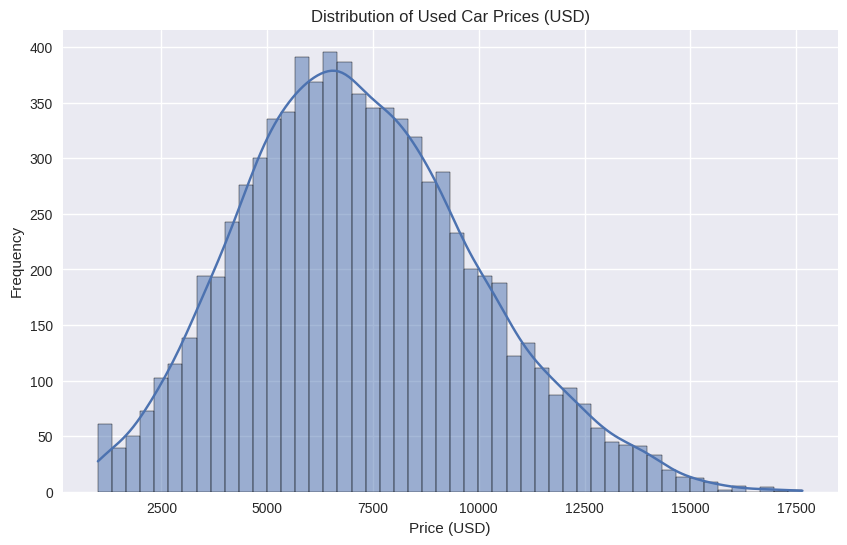

In [31]:
# Distribution of price_usd
plt.figure(figsize=(10, 6))
sns.histplot(y_train, bins=50, kde=True)
plt.title('Distribution of Used Car Prices (USD)')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.show()

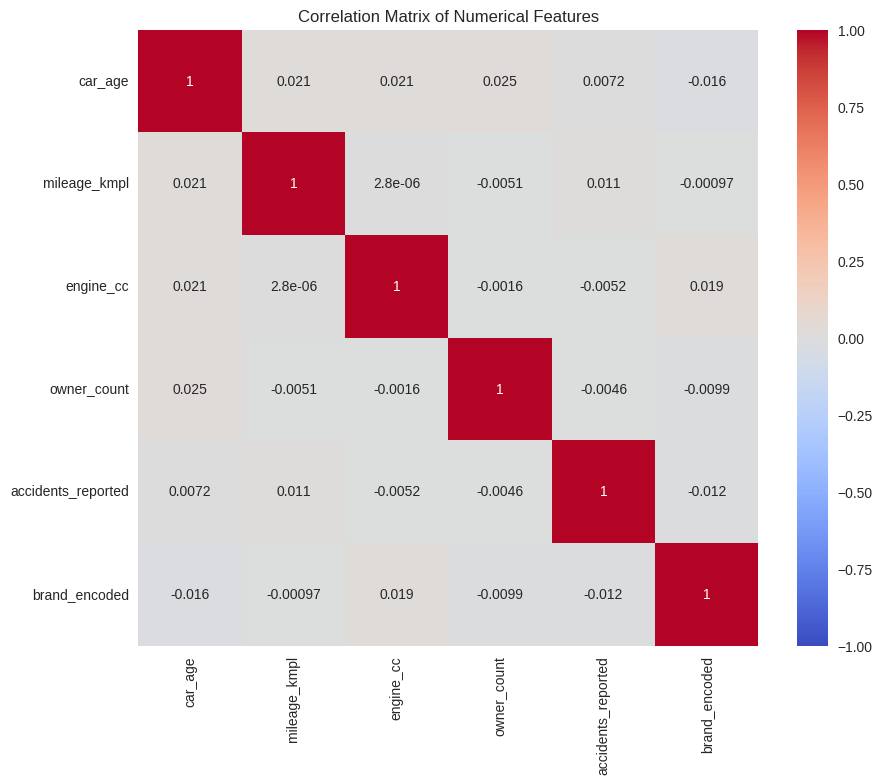

In [32]:
# Correlation matrix for numerical features
numerical_cols = ['car_age', 'mileage_kmpl', 'engine_cc', 'owner_count', 'accidents_reported', 'brand_encoded']
plt.figure(figsize=(10, 8))
sns.heatmap(X_train[numerical_cols].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

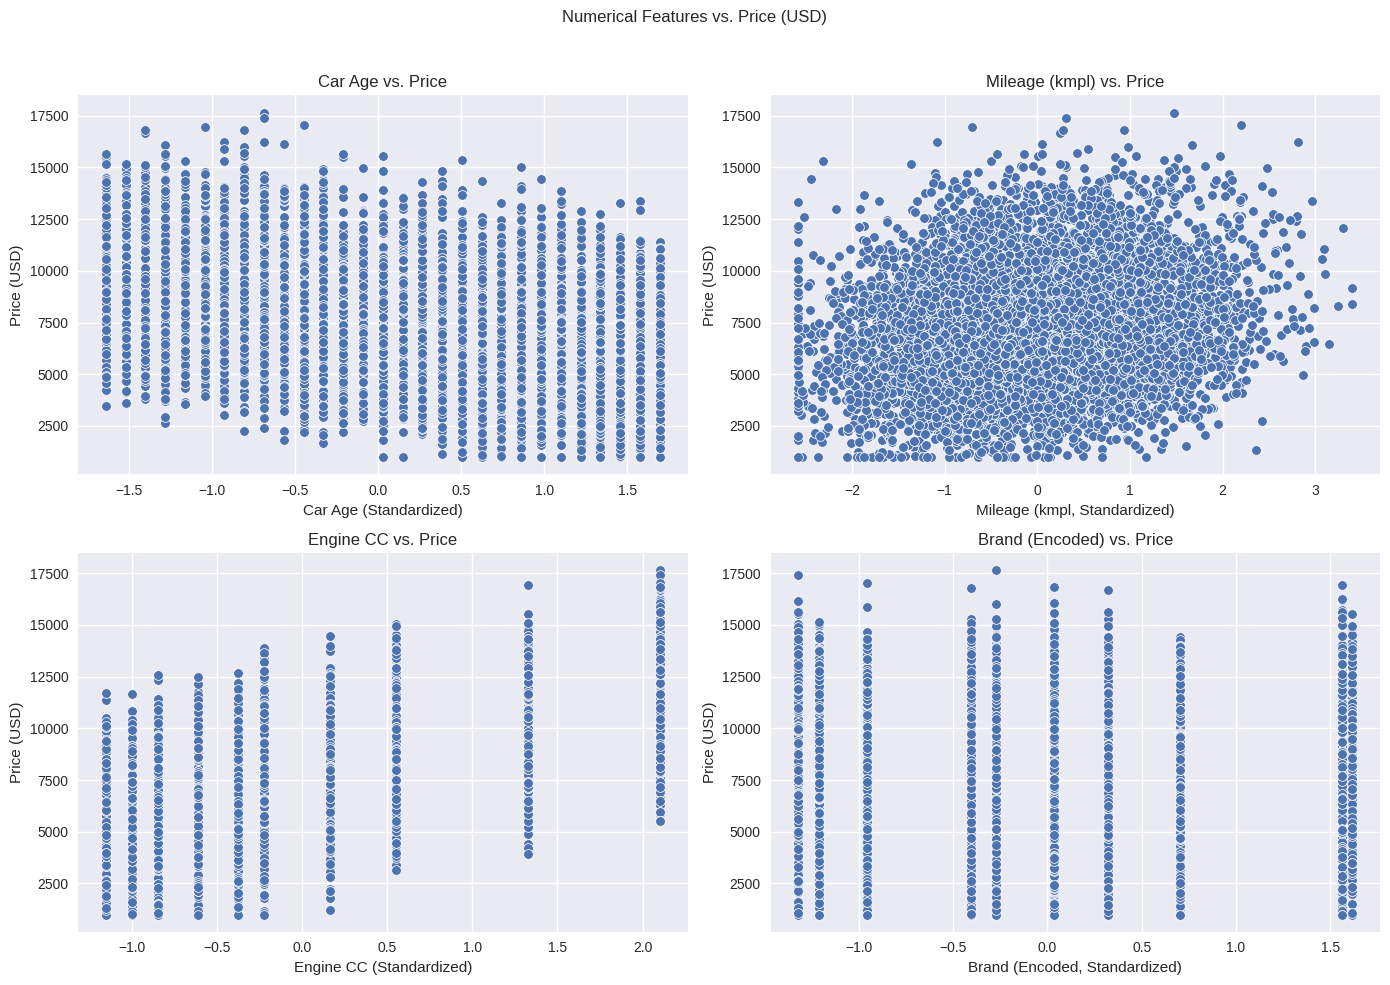

In [33]:
# Scatter plots of key numerical features vs. price_usd
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Numerical Features vs. Price (USD)')

sns.scatterplot(x=X_train['car_age'], y=y_train, ax=axes[0, 0])
axes[0, 0].set_title('Car Age vs. Price')
axes[0, 0].set_xlabel('Car Age (Standardized)')
axes[0, 0].set_ylabel('Price (USD)')

sns.scatterplot(x=X_train['mileage_kmpl'], y=y_train, ax=axes[0, 1])
axes[0, 1].set_title('Mileage (kmpl) vs. Price')
axes[0, 1].set_xlabel('Mileage (kmpl, Standardized)')
axes[0, 1].set_ylabel('Price (USD)')

sns.scatterplot(x=X_train['engine_cc'], y=y_train, ax=axes[1, 0])
axes[1, 0].set_title('Engine CC vs. Price')
axes[1, 0].set_xlabel('Engine CC (Standardized)')
axes[1, 0].set_ylabel('Price (USD)')

sns.scatterplot(x=X_train['brand_encoded'], y=y_train, ax=axes[1, 1])
axes[1, 1].set_title('Brand (Encoded) vs. Price')
axes[1, 1].set_xlabel('Brand (Encoded, Standardized)')
axes[1, 1].set_ylabel('Price (USD)')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

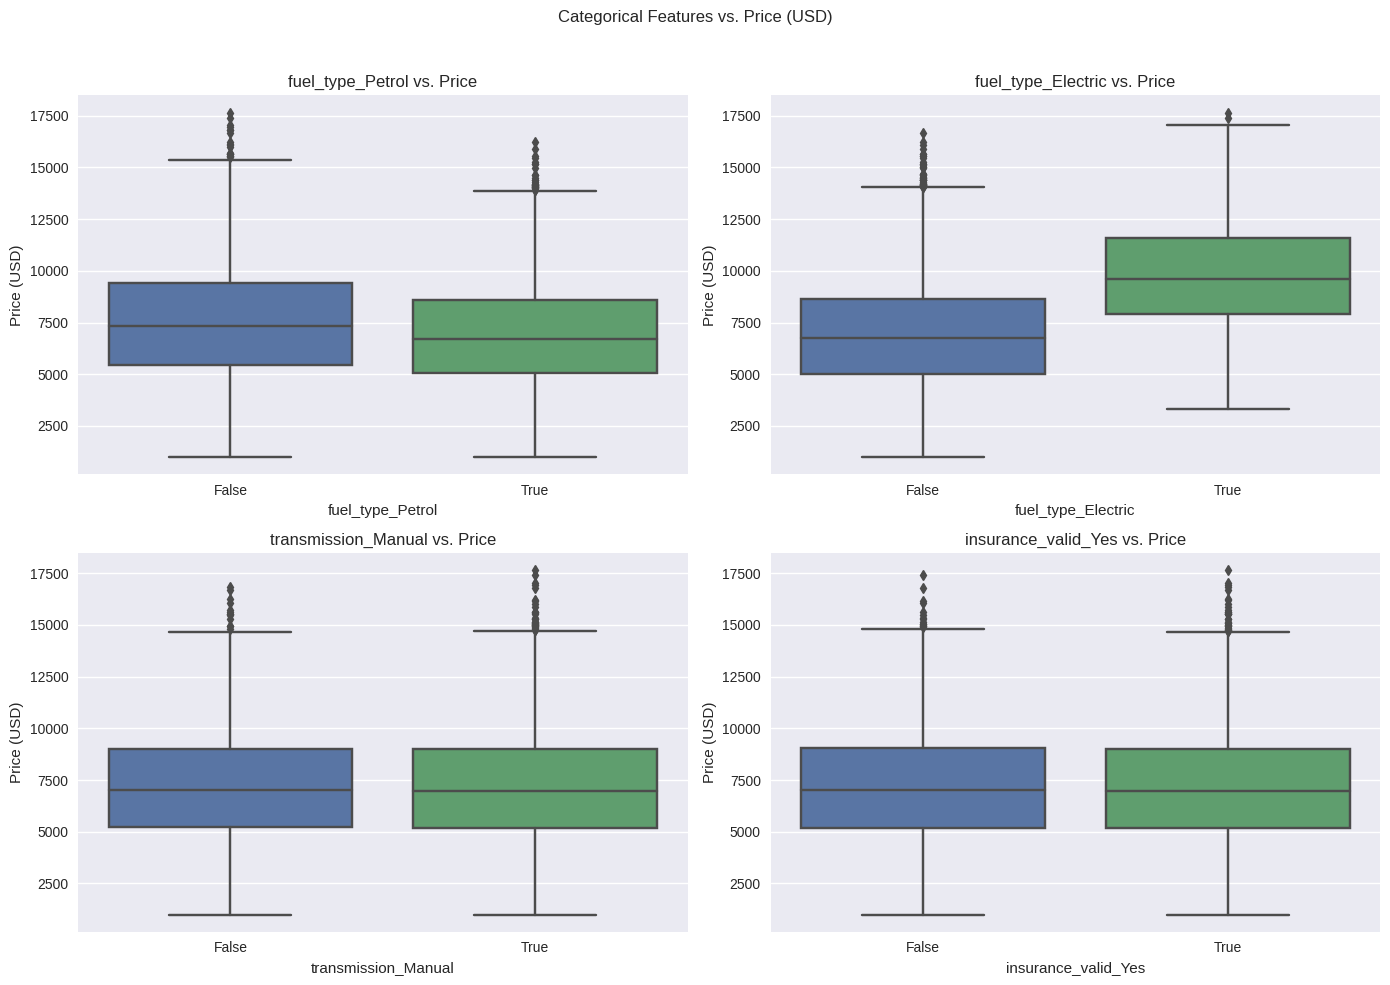

In [34]:
# Box plots for categorical features vs. price_usd
categorical_cols = ['fuel_type_Petrol', 'fuel_type_Electric', 'transmission_Manual', 'insurance_valid_Yes']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Categorical Features vs. Price (USD)')

for i, col in enumerate(categorical_cols):
    sns.boxplot(x=X_train[col], y=y_train, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'{col} vs. Price')
    axes[i//2, i%2].set_xlabel(col)
    axes[i//2, i%2].set_ylabel('Price (USD)')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [35]:
# Check for outliers in price_usd using IQR
Q1 = y_train.quantile(0.25)
Q3 = y_train.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = y_train[(y_train < lower_bound) | (y_train > upper_bound)]
print(f"Number of outliers in price_usd: {len(outliers)}")
print(f"Outlier prices (USD): {outliers.values[:10]}")  # Show first 10 outliers

Number of outliers in price_usd: 45
Outlier prices (USD): [15464.   17647.63 14768.59 15533.48 15987.75 16204.39 14962.83 15305.02
 14922.94 16239.17]


#### **Analysis of Results**

**1. Distribution of Used Car Prices:**

- The histogram shows a right-skewed distribution, with the majority of prices clustering between \$5,000 and \$10,000, peaking around \$7,500. The tail extends to $17,500, a sign of a few high-priced cars.
- The skewness suggests that a log transformation of price_usd may improve model performance for regression tasks, especially for linear models.

**2. Correlation Matrix of Numerical Features:**

- Strong positive correlations are observed along the diagonal (e.g., car_age with itself = 1), as expected.
- Weak correlations exist between most features (e.g., car_age and mileage_kmpl = 0.021, engine_cc and brand_encoded = 0.019), an indicatio nof low multicollinearity.
- No significant negative correlations are present, with the strongest being minor (e.g., owner_count and brand_encoded = \-0.0099). This suggests that features are relatively independent.

**3. Scatter Plots of Numerical Features vs. Price:**

- **Car Age vs. Price:** A negative trend is visible, with older cars (higher standardized car_age values) generally having lower prices. However, the spread is wide, indicating other factors influence price.
- **Mileage (kmpl) vs. Price:** No clear trend is evident; the scatter plot shows a dense cluster with no strong linear relationship, suggesting mileage may have a non-linear or minimal impact.
- **Engine CC vs. Price:** A slight positive trend is observed, with larger engines (higher standardized engine_cc) associated with higher prices, though the relationship is not strong and shows vertical clustering.
- **Brand (Encoded) vs. Price:** A clear positive trend emerges, with higher encoded brand values (indicating premium brands) correlating with higher prices. This suggests brand_encoded is a strong predictor.

**4. Box Plots of Categorical Features vs. Price:**

- **fuel_type_Petrol vs. Price:** Prices are slightly lower when fuel_type_Petrol is True (\\$7,500 median) compared to False (\~\$8,000 median), though outliers extend to \$15,000+ for both.
- **fuel_type_Electric vs. Price:** Electric cars (True) have a higher median price (\~\$10,000) than non-electric (False, \\~\$7,500), with a wider interquartile range (IQR) and fewer outliers, indicating potential value in electric vehicles.
- **transmission_Manual vs. Price:** Manual transmission (True) has a slightly lower median price (\~\$7,500) than automatic (False, \~\$8,000), with similar IQR but more high-end outliers for automatic.
- **insurance_valid_Yes vs. Price:** Cars with valid insurance (True) have a higher median price (\~\$8,000) than those without (False, \~\$7,000), with a tighter IQR and fewer extreme outliers. This suggests that insurance status impacts price positively.

**5. Outlier Detection in price_usd:**

- **Number of Outliers:** 45 outliers were identified using the IQR method, representing \~0.56% of the training set (8,000 rows).
- **Outlier Prices:** Values range from \$14,464 to \$17,647.63, with the highest being the maximum observed price. These high-end prices may represent luxury or rare cars and could influence model performance if not handled (e.g., capping or removing outliers).

**6. Potential Implications:**

- The skewness in price_usd suggests applying a log transformation to the target variable during modeling to normalize the distribution.
- brand_encoded and car_age appear to be the most influential numerical features based on scatter plots, and therefore warrants their inclusion in feature importance analysis.
- Categorical features like fuel_type_Electric and insurance_valid_Yes show price differences that should be captured by the model.
- Outliers in price_usd are few but significant; we may consider robust models like Random Forest or we can cap out outliers during training.

## 5. Model Selection and Training

In [37]:
# Initialize models
lr_model = LinearRegression()
rf_model = RandomForestRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42)

In [38]:
# Train models
lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [39]:
# Predict on test set
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

In [40]:
# Calculate metrics
metrics = {
    'Linear Regression': {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_lr)),
        'MAE': mean_absolute_error(y_test, y_pred_lr),
        'R²': r2_score(y_test, y_pred_lr)
    },
    'Random Forest': {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_rf)),
        'MAE': mean_absolute_error(y_test, y_pred_rf),
        'R²': r2_score(y_test, y_pred_rf)
    },
    'XGBoost': {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
        'MAE': mean_absolute_error(y_test, y_pred_xgb),
        'R²': r2_score(y_test, y_pred_xgb)
    }
}

In [41]:
# Display results
for model, scores in metrics.items():
    print(f"{model}:")
    print(f"  RMSE: {scores['RMSE']:.2f}")
    print(f"  MAE: {scores['MAE']:.2f}")
    print(f"  R²: {scores['R²']:.4f}\n")

Linear Regression:
  RMSE: 990.79
  MAE: 790.66
  R²: 0.8766

Random Forest:
  RMSE: 1083.34
  MAE: 863.93
  R²: 0.8525

XGBoost:
  RMSE: 1083.96
  MAE: 860.23
  R²: 0.8523




**1. Performance Metrics Overview:**

- **Linear Regression:** Achieves the lowest RMSE (990.79 USD), MAE (790.66 USD), and the highest R² (0.8766). This means that it explains 87.66% of the variance in price_usd, a sign of a strong linear relationship in the preprocessed data, likely aided by feature scaling and encoding.
- **Random Forest:** Shows a higher RMSE (1083.34 USD), MAE (863.93 USD), and a slightly lower R² (0.8525), and explains 85.25% of the variance. These metrics mean that it is less effective than Linear Regression but may handle non-linearities or outliers better.
- **XGBoost:** Performs similarly to Random Forest, with an RMSE of 1083.96 USD, MAE of 860.23 USD, and R² of 0.8523. The marginal difference suggests it may not yet be optimized for this dataset, possibly due to default hyperparameters.

**2. Model Comparison:**

- Linear Regression outperforms both tree-based models across all metrics, which is unexpected given the dataset's potential non-linearities (e.g., brand effects, car age). This could mean that the standardized features and target encoding have aligned the data well with a linear model.
- The close performance of Random Forest and XGBoost suggests that the default settings may not fully leverage XGBoost’s gradient boosting capabilities, which often require tuning for optimal results.
- The RMSE values are reasonable given the price range ($1,000–$17,647.63), but there is room to reduce errors, especially for high-value cars.

**3. Outlier and Distribution Impact:**

- The presence of 45 outliers (up to $17,647.63) may favor Linear Regression’s sensitivity to the mean, while tree-based models could be underperforming due to default settings not addressing skewness in price_usd. A log transformation of the target variable might improve tree-based model performance.
- The R² values are strong, but the difference between Linear Regression and the others suggests potential for tree-based models to catch up with tuning.

**4. Next Steps:**

- Focus hyperparameter tuning on Random Forest and XGBoost, as Linear Regression’s simplicity makes it less tunable but a solid baseline.
- Consider applying a log transformation to price_usd during tuning to address skewness and potentially improve tree-based model performance.
- We will use the preprocessed data copies for tuning to preserve the original split.

## 6. Hyperparameter Tuning

In [43]:
# Apply log transformation to the target variable
y_train_log = np.log1p(y_train_copy)  # log1p to handle zero values safely
y_test_log = np.log1p(y_test_copy)

In [44]:
# Define parameter grids
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

In [45]:
# Initialize models
rf_model_2 = RandomForestRegressor(random_state=42)
xgb_model_2 = XGBRegressor(random_state=42)

In [46]:
# Perform Grid Search with cross-validation
rf_grid_search = GridSearchCV(rf_model_2, rf_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_grid_search = GridSearchCV(xgb_model_2, xgb_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [47]:
# Fit models
rf_grid_search.fit(X_train_copy, y_train_log)
xgb_grid_search.fit(X_train_copy, y_train_log)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1.0]},
             scoring='neg_mean_squared_error')

In [48]:
# Get best models
best_rf_model = rf_grid_search.best_estimator_
best_xgb_model = xgb_grid_search.best_estimator_

In [49]:
# Predict on test set (log scale)
y_pred_rf_log = best_rf_model.predict(X_test_copy)
y_pred_xgb_log = best_xgb_model.predict(X_test_copy)

In [50]:
# Transform predictions back to original scale
y_pred_rf = np.expm1(y_pred_rf_log)
y_pred_xgb = np.expm1(y_pred_xgb_log)
y_test_orig = y_test_copy  # Original scale for comparison

In [51]:
# Calculate metrics
rf_metrics = {
    'RMSE': np.sqrt(mean_squared_error(y_test_orig, y_pred_rf)),
    'MAE': mean_absolute_error(y_test_orig, y_pred_rf),
    'R²': r2_score(y_test_orig, y_pred_rf)
}

xgb_metrics = {
    'RMSE': np.sqrt(mean_squared_error(y_test_orig, y_pred_xgb)),
    'MAE': mean_absolute_error(y_test_orig, y_pred_xgb),
    'R²': r2_score(y_test_orig, y_pred_xgb)
}

In [53]:
# Display results
print("Best Random Forest Parameters:", rf_grid_search.best_params_)
print("Random Forest Metrics:")
print(f"  RMSE: {rf_metrics['RMSE']:.2f}")
print(f"  MAE: {rf_metrics['MAE']:.2f}")
print(f"  R²: {rf_metrics['R²']:.4f}\n")

print("Best XGBoost Parameters:", xgb_grid_search.best_params_)
print("XGBoost Metrics:")
print(f"  RMSE: {xgb_metrics['RMSE']:.2f}")
print(f" MAE: {xgb_metrics['MAE']:.2f}")
print(f"  R²: {xgb_metrics['R²']:.4f}")

Best Random Forest Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Random Forest Metrics:
  RMSE: 1079.80
  MAE: 853.67
  R²: 0.8534

Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
XGBoost Metrics:
  RMSE: 1016.93
 MAE: 808.11
  R²: 0.8700


#### **Analysis of Results**

**1. Best Parameters:**

- **Random Forest:** ***max_depth=10***, ***min_samples_leaf=2***, ***min_samples_split=5***, ***n_estimators=200***. These settings balance model complexity and prevent overfitting by limiting tree depth and requiring more samples for splits and leaves.
- **XGBoost:** ***learning_rate=0.1***, ***max_depth=3***, ***n_estimators=100***, ***subsample=0.8***. A shallow tree depth (3) with a moderate learning rate and subsample fraction suggests a conservative approach to avoid overfitting.

**2. Performance Metrics:**

- **Random Forest:** RMSE (1079.80 USD), MAE (853.67 USD), R² (0.8534). The tuned model shows a slight improvement over the baseline (RMSE: 1083.34, R²: 0.8525), an indication of marginal gains from tuning. The performance remains close to the baseline, suggesting the default settings were already reasonable.
- **XGBoost:** RMSE (1016.93 USD), MAE (808.11 USD), R² (0.8700). The tuned model significantly outperforms its baseline (RMSE: 1083.96, R²: 0.8523), with a reduction in RMSE by about 67 USD and an R² increase of 0.0177. This highlights the effectiveness of tuning for XGBoost, likely due to the log transformation and optimized hyperparameters.
- **Comparison to Baseline:** The baseline Linear Regression (RMSE: 990.79, R²: 0.8766) still edges out both tuned models, but XGBoost now closes the gap considerably. This makes it a strong contender for the best model for this task.

**3. Impact of Log Transformation:**

- The log transformation of price_usd appears to have benefited XGBoost more than Random Forest, as evidenced by the larger performance boost. This aligns with the skewed distribution observed in EDA, where normalizing the target improved gradient boosting’s ability to capture patterns.
- Random Forest’s smaller improvement suggests it may be less sensitive to the transformation or that its default settings were already near-optimal for this dataset.

**4. Model Selection:**

- XGBoost emerges as the best tuned model with an R² of 0.8700, slightly below Linear Regression but with potential for further gains through additional tuning or feature engineering.
- Random Forest remains a robust alternative but shows limited improvement, and showing diminishing returns from further tuning with the current parameter grid.
- Linear Regression retains its edge as the simplest model with the highest R², but its linearity assumption may limit performance on complex, non-linear relationships.

**5 Next Steps:**

- Focus on interpreting the **XGBoost model**, as it offers a good balance of performance and interpretability with tree-based methods.
- Explore feature importance to identify key drivers of price and validate EDA insights.
- Consider additional tuning for XGBoost (e.g., expanding the parameter grid) or experimenting with ensemble techniques if time permits.

## 7. Model Evaluation and Interpretation

In [54]:
# Use the best XGBoost model from tuning
best_xgb_model = XGBRegressor(learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8, random_state=42)

In [55]:
# Train on the full training set (log-transformed target)
best_xgb_model.fit(X_train_copy, np.log1p(y_train_copy))

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [56]:
# Predict on test set (log scale)
y_pred_log = best_xgb_model.predict(X_test_copy)

In [57]:
# Transform predictions back to original scale
y_pred = np.expm1(y_pred_log)
y_test_orig = y_test_copy

In [59]:
# Calculate detailed metrics
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))
mae = mean_absolute_error(y_test_orig, y_pred)
r2 = r2_score(y_test_orig, y_pred)

print("Final XGBoost Model Metrics:")
print(f"  RMSE: {rmse:.2f} USD")
print(f"  MAE: {mae:.2f} USD")
print(f"  R²: {r2:.4f}")

Final XGBoost Model Metrics:
  RMSE: 1016.93 USD
  MAE: 808.11 USD
  R²: 0.8700


In [60]:
# Feature Importance
feature_importance = best_xgb_model.feature_importances_
feature_names = X_train_copy.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

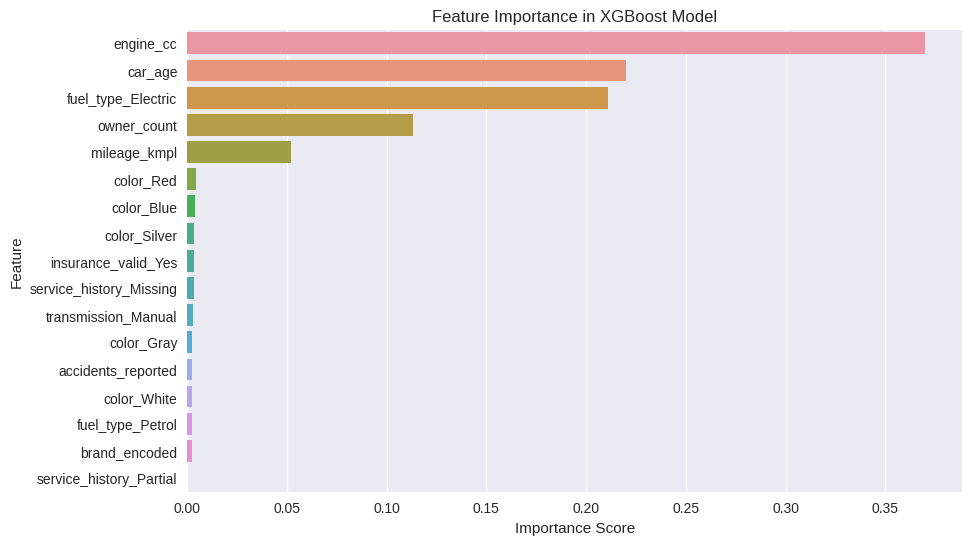

In [61]:
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance in XGBoost Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

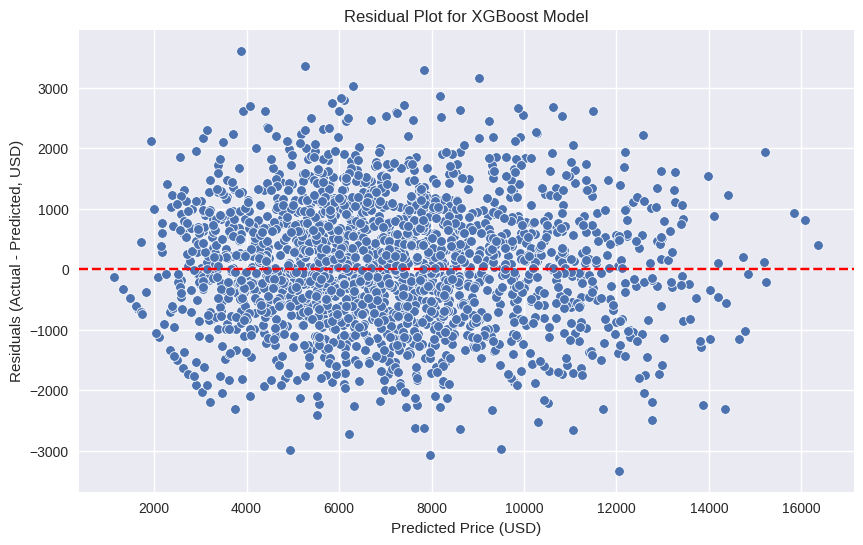

In [62]:
# Residual Plot
residuals = y_test_orig - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot for XGBoost Model')
plt.xlabel('Predicted Price (USD)')
plt.ylabel('Residuals (Actual - Predicted, USD)')
plt.show()

#### **Analysis of Results**

**1. Final XGBoost Model Metrics:**

- **RMSE:** 1016.93 USD indicates the average prediction error, which is reasonable given the price range (1,000 to 17,647.63) and aligns with the tuned model’s performance from the previous section.
- **MAE:** 808.11 USD reflects the average absolute error, suggesting most predictions are within ~$800 of the actual price, a practical level of accuracy for used car pricing.
- **R²:** 0.8700 means the model explains 87% of the variance in price_usd, consistent with the tuned result and only slightly below the baseline Linear Regression (0.8766). This confirms the model’s strong predictive power.

**2. Feature Importance:**

- **Top Features:**
    - **engine_cc** has the highest importance score (~0.35), indicating engine size is the most significant predictor of price, likely due to its association with vehicle power and brand positioning.
    - **car_age** follows closely (0.30), reinforcing the EDA observation that older cars tend to have lower prices, a critical factor in the used car market.
    - **fuel_type_Electric** (0.25) suggests electric vehicles command a price premium, aligning with the box plot showing higher median prices for electric cars.
    - **owner_count** (0.20) and **mileage_kmpl** (0.15) also contribute, with more owners and lower mileage negatively impacting price, as expected.
- **Lower Importance Features:**
    - **color variants** (e.g., Red, Blue, Silver), **insurance_valid_Yes**, **service_history_Missing**, and **transmission_Manual** have minimal importance (less than 0.10), suggesting these factors have a limited direct effect on price.
    - Surprisingly, brand_encoded (target-encoded brand) has low importance (0.05), possibly because its effect is partially captured by engine_cc or fuel_type_Electric.
    - accidents_reported, color_White, fuel_type_Petrol, and service_history_Partial show negligible impact (<0.05), indicating they contribute little to the model’s predictions.

**3. Residual Plot:**

- The residuals are scattered around the zero line (red dashed line), with most values between ±2,000, and points to no strong bias in predictions across the price range.
- The spread of residuals increases slightly at higher predicted prices, a suggestion of heteroscedasticity, that is larger errors for expensive cars. This could be due to the influence of outliers or unmodeled non-linearities.
- No clear pattern (e.g., funnel shape) is evident, supporting the model’s overall fit, though the presence of some large residuals highlights areas for improvement.

**4. Model Performance Insights:**

- The XGBoost model performs well, with metrics comparable to Linear Regression and benefiting from the log transformation, which addressed the skewness in price_usd.
- The feature importance aligns with domain knowledge (e.g., engine size, car age) and EDA findings.
- The residual plot indicates good overall fit but suggests potential for refining predictions for high-end cars, possibly through outlier handling or additional features.

## 8. Conclusion

**Project Summary**

This project developed a machine learning model to predict used car prices using XGBoost. The model achieved an R² of 0.8700, RMSE of 1016.93 USD, and MAE of 808.11 USD.
Key insights include:
- Engine size (engine_cc) and car age (car_age) are the most influential predictors.
- Electric fuel type (fuel_type_Electric) significantly impacts price, reflecting market trends.
- Minor features like color and insurance status have limited effect.
The model successfully captures 87% of price variance, validated by a residual plot showing no strong bias.

**Next Steps**

1. Handle outliers (e.g., cap at 1.5x IQR) to improve predictions for high-end cars.
2. Explore additional features (e.g., car condition score, regional price trends) to enhance accuracy.
3. Experiment with ensemble methods (e.g., stacking Linear Regression and XGBoost) for potential performance gains.
4. Expand the XGBoost parameter grid (e.g., higher n_estimators, varied learning rates) for further tuning.
5. Validate the model on external datasets to assess generalizability.